In [1]:
# Setup scenario
from copy import deepcopy
import json
from pathlib import Path

from constants import DATA_ENTITIES_DIR, DATA_HAZARDS_DIR, DATA_TEMP_DIR, REQUIREMENTS_DIR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg, risk_rp_100, risk_rp_250
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

from costben.costben_handler import CostBenefitHandler
from entity.entity_handler import EntityHandler
from exposure.exposure_handler import ExposureHandler
from hazard.hazard_handler import HazardHandler
from impact.impact_handler import ImpactHandler

from base_handler import BaseHandler
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])

base_handler = BaseHandler()
costben_handler = CostBenefitHandler()
entity_handler = EntityHandler()
exposure_handler = ExposureHandler()
hazard_handler = HazardHandler()
impact_handler = ImpactHandler()


# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', flood, 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"  # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"  # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = "rcp26"  # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"  # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']
annual_growth = 1.01

client = Client()

# const exposureNonEconomicDict = {
#   thailand: ["tree_crops_farmers", "grass_crops_farmers", "buddhist_monks", "water_users", "roads", "students"],
#   egypt: ["hospitalised_people", "students", "diarrhea_patients", "roads"],
# };

# const exposureEconomicDict = {
#   thailand: ["tree_crops", "grass_crops", "wet_markets"],
#   egypt: ["crops", "livestock", "power_plants", "hotels"],
# };

In [ ]:
import h5py
import rasterio

def read_mat():
    with h5py.File(DATA_HAZARDS_DIR / "hazard_D_THA_rcp45.mat", 'r') as f:
        # Print all items in the root
        print("Items in the root:", list(f.keys()))

        # Access the 'hazard' group/dataset
        hazard = f['hazard']
        print("Items in 'hazard':", list(hazard.keys()))

        # If 'hazard' contains further groups or datasets, access them
        for item in hazard:
            print(f"Exploring {item}:")
            data = hazard[item]
            
            # Check if this is a dataset or a group
            if isinstance(data, h5py.Dataset):
                print(f"Dataset {item} found with shape {data.shape} and data type {data.dtype}")
            else:
                print(f"Group {item} contains: {list(data.keys())}")

            # If the item is stored by reference (common in MATLAB structures)
            if data.dtype == 'O':  # Object references
                # This will go through each reference and try to resolve it
                for ref in data:
                    referenced_object = f[data[ref][0]]  # Access by reference
                    print(f"Referenced object for {ref}: {referenced_object.shape}")

                    # Optionally, you can load the data into an array or similar
                    # print(np.array(referenced_object))

def read_tif():
    with rasterio.open(DATA_HAZARDS_DIR / "hazard_HW_EGY_rcp45.tif") as src:
        print(f'Number of bands: {src.count}')
        # Loop through each band
        # for i in range(1, src.count + 1):
        #     band = src.read(i)
        #     print(band)
        #     meta = src.tags(i)
        #     print(f'  Metadata for Band {i}: {meta}')


2024-08-28 12:37:49,061 - climada.hazard.base - WARNING - Impact function id=201 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-08-28 12:37:50,621 - climada.hazard.base - WARNING - Impact function id=201 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.

Measure                  Cost (USD )    Benefit (USD )    Benefit/Cost
---------------------  -------------  ----------------  --------------
vegetation management     6.6887e+07      -2.66155e+09   -39.7917
risk transfer             2.1e+07          3.27771e-08     1.56081e-15

--------------------  -----------  ------
Total climate risk:   2.54558e+08  (USD )
Average annual risk:  1.50423e+07  (USD )
Residual risk:        2.91611e+09  (USD )
--------------------  -----------  ------
Net Present Values


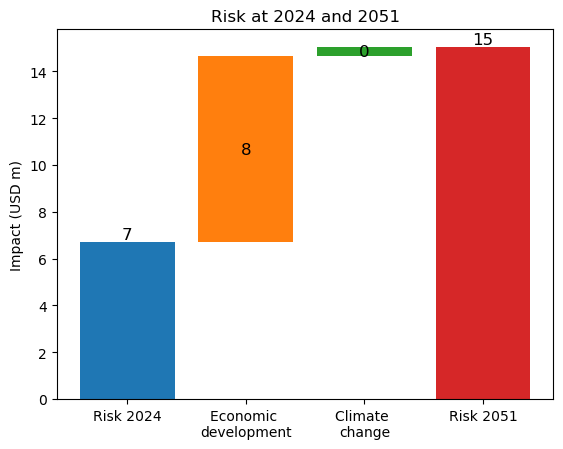

In [2]:
# Example Drought App
entity_present = entity_handler.get_entity_from_xlsx(
    DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_cal_python - Calibrated.xlsx"
)
entity_present.check()
entity_present.exposures.ref_year = 2024

entity_future = entity_handler.get_future_entity(entity_present, 2051, 0.0294)
entity_future.check()


hazard_present = Hazard().from_hdf5(DATA_HAZARDS_DIR / "hazard_D_THA_historical.h5")
hazard_present.haz_type = "D"
hazard_present.check()

hazard_future = Hazard().from_hdf5(DATA_HAZARDS_DIR / "hazard_D_THA_rcp45.h5")
hazard_future.haz_type = "D"
hazard_future.check()

hazard_present.units = "SPI"
hazard_future.units = "SPI"

hazard_present.centroids.set_geometry_points()
hazard_future.centroids.set_geometry_points()

hazard_present.intensity_thres = -4
hazard_future.intensity_thres = -4


# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact(save_mat=True)
impact_future = ImpactCalc(
    entity_future.exposures, entity_future.impact_funcs, hazard_future
).impact(save_mat=True)


costben = costben_handler.calculate_cost_benefit(
    hazard_present, entity_present, hazard_future, entity_future, 2051
)
# costben_handler.plot_cost_benefit(costben)
# costben_handler.plot_waterfall(
#     costben, hazard_present, entity_present, hazard_future, entity_future
# )

# exposure_handler.generate_exposure_geojson(entity_future.exposures, "Thailand")
# hazard_handler.generate_hazard_geojson(hazard_future, "Thailand")
# impact_handler.generate_impact_geojson(impact_future, "Thailand")
ax = costben.plot_waterfall(hazard_present, entity_present, hazard_future, entity_future
)
# costben.plot_arrow_averted(ax)
# costben.plot_event_view((10, 15))
# costben.plot_waterfall_accumulated(hazard_present, entity_present, entity_future)

In [107]:
base_handler.read_parquet_file(DATA_TEMP_DIR/"exposure_report_data.parquet")
# base_handler.read_parquet_file(DATA_TEMP_DIR/"hazard_report_data.parquet")
# base_handler.read_parquet_file(DATA_TEMP_DIR/"impact_report_data.parquet")

,Admin 1,Admin 2,Latitude,Longitude,Asset Value,Asset UoM
0,Bangkok,Pom Prap Sattru Phai,13.753331,100.513534,30.219061,People
1,Bangkok,Samphanthawong,13.740552,100.504422,120.876245,People
2,Bangkok,Samphanthawong,13.734328,100.513465,60.438122,People
3,Bangkok,Pom Prap Sattru Phai,13.751665,100.506754,60.438122,People
4,Bangkok,Pom Prap Sattru Phai,13.743737,100.511816,90.657184,People
...,...,...,...,...,...,...
7127,Narathiwat Province,Sukhirin,5.881583,101.737750,3.777383,People
7128,Narathiwat Province,Sukhirin,5.948708,101.710089,11.332148,People
7129,Samut Sakhon Province,Mueang Samut Sakhon,13.480536,100.130527,7.554765,People
7130,Narathiwat Province,Si Sakhon,6.226694,101.545548,7.554765,People


In [94]:
entity_present = Entity.from_excel(
    DATA_ENTITIES_DIR / "entity_TODAY_THA_D_tree_crops.xlsx"
)
# Set exposure ref year
entity_present.exposures.ref_year = 2024
entity_present.check()

# Set future Entity
entity_future = deepcopy(entity_present)
entity_future.exposures.ref_year = 2050
growth = 0.029
entity_future.exposures.gdf["value"] = entity_future.exposures.gdf.value.values * (1 + growth) ** (
    entity_future.exposures.ref_year - entity_present.exposures.ref_year
)
entity_future.check()

# Set present Hazard
hazard_present = Hazard.from_hdf5(
    DATA_HAZARDS_DIR / "hazard_D_THA_historical.h5",
)
hazard_present.units = "m"
hazard_present.centroids.set_geometry_points()
hazard_present.intensity_thres = -4
hazard_present.check()

# Set future hazard
hazard_future = Hazard.from_hdf5(
    DATA_HAZARDS_DIR / "hazard_HW_EGY_rcp45.h5",
    attrs={
        "frequency": np.array([0.5, 0.2, 0.1, 0.04]),
        "event_id": np.array([1, 2, 3, 4]),
        "units": "number of days",
    },
    haz_type="HW",
    band=[1, 2, 3, 4],
)
hazard_future.units = "number of days"
hazard_future.centroids.set_geometry_points()
hazard_future.intensity_thres = 0
hazard_future.check()

# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact()
impact_future = ImpactCalc(
    entity_future.exposures, entity_future.impact_funcs, hazard_future
).impact()

TypeError: from_hdf5() got an unexpected keyword argument 'attrs'

In [3]:
# Example Drought Climada
# Set present Entity
entity_present = Entity.from_excel(
    DATA_ENTITIES_DIR / "entity_TODAY_THA_D_tree_crops.xlsx"
)
# Set exposure ref year
entity_present.exposures.ref_year = 2024
entity_present.check()

# Set future Entity
entity_future = deepcopy(entity_present)
entity_future.exposures.ref_year = 2050
growth = 0.029
entity_future.exposures.gdf["value"] = entity_future.exposures.gdf.value.values * (1 + growth) ** (
    entity_future.exposures.ref_year - entity_present.exposures.ref_year
)
entity_future.check()

# Set present Hazard
hazard_present = Hazard.from_hdf5(
    DATA_HAZARDS_DIR / "hazard_D_THA_historical.h5",
)
hazard_present.units = "m"
hazard_present.centroids.set_geometry_points()
hazard_present.intensity_thres = -4
hazard_present.check()

# Set future hazard
hazard_future = Hazard.from_hdf5(
    DATA_HAZARDS_DIR / "hazard_HW_EGY_rcp45.h5",
    attrs={
        "frequency": np.array([0.5, 0.2, 0.1, 0.04]),
        "event_id": np.array([1, 2, 3, 4]),
        "units": "number of days",
    },
    haz_type="HW",
    band=[1, 2, 3, 4],
)
hazard_future.units = "number of days"
hazard_future.centroids.set_geometry_points()
hazard_future.intensity_thres = 0
hazard_future.check()

# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact()
impact_future = ImpactCalc(
    entity_future.exposures, entity_future.impact_funcs, hazard_future
).impact()

# Calculate cost-benefit
cost_benefit = CostBenefit()
cost_benefit.calc(
    hazard=hazard_present,
    entity=entity_present,
    haz_future=hazard_future,
    ent_future=entity_future,
    risk_func=risk_aai_agg,
    save_imp=True,
)

# Plot cost benefit waterfall
axis = cost_benefit.plot_waterfall(
    hazard_present,
    entity_present,
    hazard_future,
    entity_future,
    risk_func=risk_aai_agg,
)

TypeError: from_hdf5() got an unexpected keyword argument 'attrs'

In [24]:
# Example Flood Egypt App
entity_present = entity_handler.get_entity_from_xlsx(
    DATA_ENTITIES_DIR / "entity_TODAY_EGY_FL_diarrhea_patients.xlsx"
)
entity_present.check()
entity_present.exposures.ref_year = 2024

entity_future = entity_handler.get_future_entity(entity_present, 2050, 0.0129)
entity_future.check()


hazard_present = hazard_handler.get_hazard(
    hazard_type="flood", filepath=DATA_HAZARDS_DIR / "hazard_FL_EGY_historical.tif"
)
hazard_present.haz_type = "FL"
hazard_present.check()

hazard_future = hazard_handler.get_hazard(
    hazard_type="flood", filepath=DATA_HAZARDS_DIR / "hazard_FL_EGY_rcp26.tif"
)
hazard_future.haz_type = "FL"
hazard_future.check()

hazard_present.units = "m"
hazard_future.units = "m"

hazard_present.centroids.set_geometry_points()
hazard_future.centroids.set_geometry_points()

hazard_present.intensity_thres = 0
hazard_future.intensity_thres = 0


# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact(save_mat=True)
impact_future = ImpactCalc(
    entity_future.exposures, entity_future.impact_funcs, hazard_future
).impact(save_mat=True)


costben = costben_handler.calculate_cost_benefit(
    hazard_present, entity_present, hazard_future, entity_future, 2050
)
# costben_handler.plot_cost_benefit(costben)
# costben_handler.plot_waterfall(
#     costben, hazard_present, entity_present, hazard_future, entity_future
# )

# exposure_handler.generate_exposure_geojson(entity_future.exposures, "Thailand")
# hazard_handler.generate_hazard_geojson(hazard_future, "Thailand")
# impact_handler.generate_impact_geojson(impact_future, "Thailand")
# ax = costben.plot_waterfall(hazard_present, entity_present, hazard_future, entity_future)
# costben.plot_arrow_averted(ax)
# costben.plot_event_view((10, 15))
# costben.plot_waterfall_accumulated(hazard_present, entity_present, entity_future)

2024-10-10 10:55:16,322 - climada.hazard.base - WARNING - Impact function id=302 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-10-10 10:55:16,329 - climada.hazard.base - WARNING - Impact function id=302 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-10-10 10:55:16,335 - climada.hazard.base - WARNING - Impact function id=302 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-10-10 10:55:16,340 - climada.hazard.base - WARNING - Impact function id=302 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-10-10 10:55:16,348 - climada.hazard.base - WARNING - Impact function id=302 has mdr(0) != 0.The mean damage rat

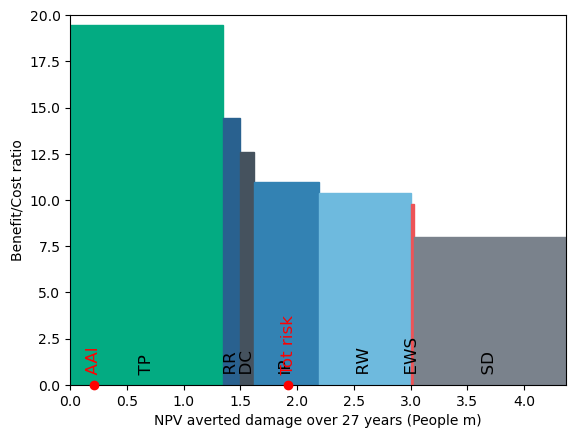

In [25]:
for key, value in costben.cost_ben_ratio.items():
    costben.cost_ben_ratio[key] = value / 1000

ax = costben.plot_cost_benefit()

In [ ]:
# Example heatwaves Thailand App
entity_present = entity_handler.get_entity_from_xlsx(
    DATA_ENTITIES_DIR / "entity_TODAY_THA_HW_buddhist_monks.xlsx"
)
entity_present.check()
entity_present.exposures.ref_year = 2024

entity_future = entity_handler.get_future_entity(entity_present, 2050, 0.0294)
entity_future.check()


hazard_present = hazard_handler.get_hazard(
    hazard_type="flood", filepath=DATA_HAZARDS_DIR / "hazard_FL_EGY_historical.tif"
)
hazard_present.haz_type = "FL"
hazard_present.check()

# hazard_future = hazard_handler.get_hazard(
#     hazard_type="flood", filepath=DATA_HAZARDS_DIR / "hazard_FL_EGY_historical.tif"
# )
# hazard_future.haz_type = "D"
# hazard_future.check()

hazard_present.units = "SPI"
# hazard_future.units = "SPI"

hazard_present.centroids.set_geometry_points()
# hazard_future.centroids.set_geometry_points()

hazard_present.intensity_thres = -4
# hazard_future.intensity_thres = -4


# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact(save_mat=True)
# impact_future = ImpactCalc(
#     entity_future.exposures, entity_future.impact_funcs, hazard_future
# ).impact(save_mat=True)


costben = costben_handler.calculate_cost_benefit(
    hazard_present, entity_present, None, None, None
)
costben_handler.plot_cost_benefit(costben)
# costben_handler.plot_waterfall(
#     costben, hazard_present, entity_present, hazard_future, entity_future
# )

# exposure_handler.generate_exposure_geojson(entity_future.exposures, "Thailand")
# hazard_handler.generate_hazard_geojson(hazard_future, "Thailand")
# impact_handler.generate_impact_geojson(impact_future, "Thailand")
# ax = costben.plot_waterfall(hazard_present, entity_present, hazard_future, entity_future)
# costben.plot_arrow_averted(ax)
# costben.plot_event_view((10, 15))
# costben.plot_waterfall_accumulated(hazard_present, entity_present, entity_future)

In [12]:
hazard_future.frequency

array([0.5 , 0.2 , 0.1 , 0.04])

In [42]:
df = pd.DataFrame(hazard_future.intensity.toarray().T, columns=[2, 5, 10, 25])
(df != 0).sum()

df2 = pd.DataFrame(df[2])
print(df2.max())
df2 = df2/0.5
print(df2.max())

2    6.637424
dtype: float32
2    13.274847
dtype: float32


In [11]:
def generate_impact_geojson(
    impact: Impact,
    country_name: str,
    return_periods: tuple = (25, 20, 15, 10),
    asset_type: str = "economic",
    exposure_type: str = None,
):
    try:
        country_iso3 = base_handler.get_iso3_country_code(country_name)
        admin_gdf = base_handler.get_admin_data(country_iso3, 2)
        coords = np.array(impact.coord_exp)
        local_exceedance_imp = impact.local_exceedance_imp(return_periods)
        local_exceedance_imp = pd.DataFrame(local_exceedance_imp).T
        data = np.column_stack((coords, local_exceedance_imp))
        columns = ["latitude", "longitude"] + [f"rp{rp}" for rp in return_periods]

        impact_df = pd.DataFrame(data, columns=columns)

        # Round the rp values based on the asset_type
        if asset_type == "economic":
            impact_df.update(impact_df[[f"rp{rp}" for rp in return_periods]].round(2))
        elif asset_type == "non_economic":
            impact_df.update(impact_df[[f"rp{rp}" for rp in return_periods]].apply(np.ceil))

        geometry = [Point(xy) for xy in zip(impact_df["longitude"], impact_df["latitude"])]
        impact_gdf = gpd.GeoDataFrame(impact_df, geometry=geometry, crs="EPSG:4326")

        # Filter impact_gdf to exclude rows where all return period values are zero
        impact_gdf = impact_gdf[
            (impact_gdf[[f"rp{rp}" for rp in return_periods]] != 0).any(axis=1)
        ]
        impact_gdf = impact_gdf.drop(columns=["latitude", "longitude"])
        impact_gdf = impact_gdf.reset_index(drop=True)

        # Calculate percentiles for each return period
        percentile_values = {}
        percentiles = (20, 40, 60, 80)
        for rp in return_periods:
            rp_data = impact_gdf[f"rp{rp}"]
            percentile_values[f"rp{rp}"] = np.percentile(rp_data, percentiles).round(1).tolist()
            percentile_values[f"rp{rp}"].insert(0, 0)

        # Assign levels based on the percentile values
        impact_gdf = impact_handler.assign_levels(impact_gdf, percentile_values)
        # Spatial join with administrative areas
        joined_gdf = gpd.sjoin(impact_gdf, admin_gdf, how="left", predicate="within")
        # TODO: Test if this needs to be refined
        joined_gdf = joined_gdf[~joined_gdf["country"].isna()]


        radius = impact_handler.get_circle_radius(impact.haz_type, country_iso3, exposure_type)
        # Convert to GeoJSON for this layer and add to all_layers_geojson
        impact_geojson = joined_gdf.__geo_interface__
        impact_geojson["_metadata"] = {
            "percentile_values": percentile_values,
            "radius": radius,
            "return_periods": return_periods,
            "title": f"Risk ({impact.unit})",
            "unit": impact.unit,
        }

        # Save the combined GeoJSON file
        # map_data_filepath = DATA_TEMP_DIR / "risks_geodata.json"
        # with open(map_data_filepath, "w", encoding="utf-8") as f:
        #     json.dump(impact_geojson, f)
        return impact_geojson
    except Exception as exception:
        print("error", f"An unexpected error occurred. More info: {exception}")


generate_impact_geojson(impact_future, 'egypt', (2, ), "economic", "crops")

,rp2,rp5,rp10,rp25,geometry,rp2_level,rp5_level,rp10_level,rp25_level
0,4456174.84,4456174.84,4456174.84,4456174.84,POINT (30.81570 30.73167),5,5,5,5
1,2399419.80,2399419.80,2399419.80,2399419.80,POINT (30.76508 30.71227),5,5,5,5
2,359231.35,359231.35,359231.35,359231.35,POINT (30.82678 30.68094),3,3,3,3
3,254021.86,254021.86,254021.86,254021.86,POINT (30.76721 30.65817),3,2,2,2
4,541649.87,541649.87,541649.87,541649.87,POINT (30.83119 30.65875),4,3,3,3
5,118871.66,118871.66,118871.66,118871.66,POINT (30.79380 30.65125),2,2,2,2
6,61429.74,61429.74,61429.74,61429.74,POINT (30.79871 30.61375),1,1,1,1
7,333774.05,333774.05,333774.05,333774.05,POINT (30.80356 30.58251),3,3,3,3
8,187394.00,187394.00,187394.00,187394.00,POINT (30.81873 30.57864),3,2,2,2
9,552530.39,552530.39,552530.39,552530.39,POINT (30.82669 30.51888),4,4,4,4


In [ ]:
def _norm_values(value):
    norm_fact = 1.
    norm_name = ''
    if value / 1.0e9 > 1:
        norm_fact = 1.0e9
        norm_name = 'bn'
    elif value / 1.0e6 > 1:
        norm_fact = 1.0e6
        norm_name = 'm'
    elif value / 1.0e3 > 1:
        norm_fact = 1.0e3
        norm_name = 'k'
    return norm_fact, norm_name


def test():
    axis=None
    if entity_future.exposures.ref_year == entity_present.exposures.ref_year:
        raise ValueError('Same reference years for future and present entities.')
    present_year = entity_present.exposures.ref_year
    future_year = entity_future.exposures.ref_year

    imp = ImpactCalc(entity_present.exposures, entity_present.impact_funcs, hazard_present)\
            .impact(assign_centroids=hazard_present.centr_exp_col not in entity_present.exposures.gdf)
    curr_risk = risk_aai_agg(imp)

    imp = ImpactCalc(entity_future.exposures, entity_future.impact_funcs, hazard_future)\
            .impact(assign_centroids=hazard_present.centr_exp_col not in entity_future.exposures.gdf)
    fut_risk = risk_aai_agg(imp)

    if not axis:
        _, axis = plt.subplots(1, 1)
    norm_fact, norm_name = _norm_values(curr_risk)

    # current situation
    print('Risk at {:d}: {:.3e}'.format(present_year, curr_risk))

    # changing future
    # socio-economic dev
    imp = ImpactCalc(entity_future.exposures, entity_future.impact_funcs, hazard_present)\
            .impact(assign_centroids=False)
    risk_dev = risk_aai_agg(imp)
    print('Risk with development at {:d}: {:.3e}'.format(future_year, risk_dev))

    # socioecon + cc
    print('Risk with development and climate change at {:d}: {:.3e}'.
                format(future_year, fut_risk))

    axis.bar(1, curr_risk / norm_fact)
    axis.text(1, curr_risk / norm_fact, str(int(round(curr_risk / norm_fact))),
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=12, color='k')
    axis.bar(2, height=(risk_dev - curr_risk) / norm_fact,
                bottom=curr_risk / norm_fact)
    axis.text(2, curr_risk / norm_fact + (risk_dev - curr_risk) / norm_fact / 2,
                str(int(round((risk_dev - curr_risk) / norm_fact))),
                horizontalalignment='center', verticalalignment='center', fontsize=12, color='k')
    axis.bar(3, height=(fut_risk - risk_dev) / norm_fact,
                bottom=risk_dev / norm_fact)
    axis.text(3, risk_dev / norm_fact + (fut_risk - risk_dev) / norm_fact / 2,
                str(int(round((fut_risk - risk_dev) / norm_fact))),
                horizontalalignment='center', verticalalignment='center', fontsize=12,
                color='k')
    axis.bar(4, height=fut_risk / norm_fact)
    axis.text(4, fut_risk / norm_fact, str(int(round(fut_risk / norm_fact))),
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=12, color='k')

    axis.set_xticks(np.arange(4) + 1)
    axis.set_xticklabels(['Risk ' + str(present_year),
                            'Economic \ndevelopment',
                            'Climate \nchange',
                            'Risk ' + str(future_year)])
    axis.set_ylabel('Impact (' + imp.unit + ' ' + norm_name + ')')
    axis.set_title('Risk at {:d} and {:d}'.format(present_year, future_year))
    return axis

test()

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "exposures"
]
hazard_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "hazard"
]

print(
    f"Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}")

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        "country_name": country_name,
    }
)

exposure_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "exposures"
        ]
    )
)
hazard_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "hazard"
        ]
    )
)

print(
    f"Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}")

In [ ]:
# Available climate scenarios and time horizons for specific hazard type in countries Thailand and Egypt
if hazard_type == "river_flood" or "wildfire":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "tropical_cyclone":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties.get("ref_year")
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "earthquake":
    available_scenarios = []
    available_time_horizons = []
if hazard_type == "flood":
    available_scenarios = []
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )

print(
    f"Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}"
)
print(
    f"Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}"
)

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": "river_flood",
        "country_name": "Thailand",
        "climate_scenario": "rcp26",
        "year_range": "2030_2050",
    }
)
hazard_dataset_infos

In [ ]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = exposure_handler.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, 2040)

In [ ]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard_present = hazard_handler.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = hazard_handler.get_hazard(
        hazard_type,
        scenario,
        time_horizon,
        country_name,
    )

In [ ]:
# Get Impact
impact_function_set = impact_handler.calculate_impact_function_set(hazard_present)
impact_present = impact_handler.calculate_impact(exposure_present, hazard_present, impact_function_set)

if scenario != "historical":
    if annual_growth > 1:
        impact_future = impact_handler.calculate_impact(
            exposure_future, hazard_future, impact_function_set)
    impact_future = impact_handler.calculate_impact(
        exposure_present, hazard_future, impact_function_set)

In [ ]:
measure_set = costben_handler.get_measure_set_from_excel('RF')
discount_rates = costben_handler.get_discount_rates_from_excel()

In [ ]:
import pandas as pd
import sqlite3

class DataFrameSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def save_dataframe(self, df, table_name):
        """
        Save a DataFrame to the SQLite database.
        
        :param df: DataFrame to save.
        :param table_name: Name of the table to save the DataFrame to.
        """
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"DataFrame saved to {table_name} table.")

    def read_dataframe(self, table_name):
        """
        Read a DataFrame from the SQLite database.
        
        :param table_name: Name of the table to read the DataFrame from.
        :return: DataFrame read from the database.
        """
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
        return df

# Example usage
db_path = 'my_data.db'  # Path to your SQLite database file
df_sqlite = DataFrameSQLite(db_path)

# Assuming you have a DataFrame `df` to save
df_sqlite.save_dataframe(exp_gdf, 'exposure')

# To read the saved DataFrame from the database
df_read = df_sqlite.read_dataframe('exposure')
print(df_read)


In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_to_df(self, excel_path, sheet_name):
        """Reads a specified sheet from an Excel file into a DataFrame."""
        return pd.read_excel(excel_path, sheet_name=sheet_name)

    def adjust_df_columns(self, df, columns_to_keep=None):
        """Adjusts DataFrame columns based on the provided list. If None, keeps all columns."""
        if columns_to_keep is not None:
            df = df[columns_to_keep]
        return df

    def save_df_to_sqlite(self, df, table_name):
        """Saves a DataFrame to an SQLite table, appending data if the table already exists."""
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists="append", index=False)

    def read_table(self, table_name):
        """Reads a table from SQLite database into a DataFrame."""
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
excel_to_sqlite = ExcelToSQLite(db_path)

# Define the sheets and corresponding table names
sheets_tables = {
    "assets": "exposures",
    "impact_functions": "impact_functions",
    "measures": "measures",
    "discount": "discount_rates",
    "names": "names",
}

# Iterate over sheets and tables, read, adjust (if needed), and save to SQLite
for sheet, table in sheets_tables.items():
    df = excel_to_sqlite.read_excel_to_df(excel_path, sheet)

    # Here you can define which columns to keep for each table if needed, e.g.:
    # if table == 'exposures':
    #     columns_to_keep = ['Column1', 'Column2']
    #     df = excel_to_sqlite.adjust_df_columns(df, columns_to_keep)
    # else:
    #     df = excel_to_sqlite.adjust_df_columns(df)

    excel_to_sqlite.save_df_to_sqlite(df, table)

In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_and_save(self, excel_path, tabs_columns_mapping):
        """
        Read specified tabs from an Excel file and save them to SQLite database.

        :param excel_path: Path to the Excel file.
        :param tabs_columns_mapping: Dict mapping tab names to their columns adjustments.
        """
        with sqlite3.connect(self.db_path) as conn:
            for tab, columns in tabs_columns_mapping.items():
                df = pd.read_excel(excel_path, sheet_name=tab)

                # Adjust columns if specified
                if columns:
                    df = df[columns]

                df.to_sql(tab, conn, if_exists="append", index=False)
                print(f"Data from {tab} tab saved to {tab} table.")

    def read_table(self, table_name):
        """
        Read data from a specified table in the SQLite database.

        :param table_name: Name of the table to read data from.
        :return: DataFrame with the table data.
        """
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
tabs_columns_mapping = {
    "assets": None,  # Specify columns as a list if you want to adjust them, or None to include all
    "impact_functions": None,
    "measures": None,
    "discount": None,
    "names": None,
}

excel_to_sqlite = ExcelToSQLite(db_path)
excel_to_sqlite.read_excel_and_save(excel_path, tabs_columns_mapping)

# Reading data from one of the tables
df_assets = excel_to_sqlite.read_table("assets")
print(df_assets)